## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [25]:
# Installing the libraries with the specified version.
# %pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost==2.0.3 threadpoolctl==3.3.0 -q

**Note:** After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To help with data preprocessing
from scipy.stats import zscore

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Loading the dataset

In [2]:
test = pd.read_csv("Test.csv")
train = pd.read_csv("Train.csv")

## Data Overview

- Observations
- Sanity checks

### Train Dataset

In [3]:
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [4]:
train.shape

(20000, 41)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

- 39 columns and 1 target column
- Columns V1 and V2 contain 18 null values
- All columns are numeric values

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


- Class imbalance present: only 5.6% of failures (Target = 1), this means failures are rare.
- Some features have extreme min max values indicating possible outliers.
- Potential Skewness log transformation or robust scaling possibly needed for highly skewed features.

In [7]:
# Checking for duplicates
train.duplicated().sum()

np.int64(0)

In [8]:
# Checking for missing values
round(train.isnull().sum() / train.isnull().count() * 100,2)

V1       0.090
V2       0.090
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

- Missing values consist of 0.09% of columns `V1` `V2`

### Test Dataset

In [9]:
test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


In [10]:
test.shape

(5000, 41)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

- There are a total of 5000 rows `V1` and `V2` contain 5 and 4 missing values

In [12]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,4995.000,-0.278,3.466,-12.382,-2.744,-0.765,1.831,13.504
V2,4994.000,0.398,3.140,-10.716,-1.649,0.427,2.444,14.079
V3,5000.000,2.552,3.327,-9.238,0.315,2.260,4.587,15.315
V4,5000.000,-0.049,3.414,-14.682,-2.293,-0.146,2.166,12.140
V5,5000.000,-0.080,2.111,-7.712,-1.615,-0.132,1.341,7.673
V6,5000.000,-1.042,2.005,-8.924,-2.369,-1.049,0.308,5.068
V7,5000.000,-0.908,1.769,-8.124,-2.054,-0.940,0.212,7.616
V8,5000.000,-0.575,3.332,-12.253,-2.642,-0.358,1.713,10.415
V9,5000.000,0.030,2.174,-6.785,-1.456,-0.080,1.450,8.851
V10,5000.000,0.019,2.145,-8.171,-1.353,0.166,1.511,6.599


- Class imbalance for target variable remains (5.6%) this is consistent across both datasets.
- Means and std for most columns are close to the training data.
- Outliers exist in both sets


In [13]:
# checking for duplicates
test.duplicated().sum()

np.int64(0)

In [14]:
# check for missing values
round(test.isnull().sum() / test.isnull().count() * 100,2)

V1       0.100
V2       0.120
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

- `V1` 0.1% missing values `V2` 0.12% missing values

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [15]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

#### Training Dataset

C:\Users\yartevillasenoraa\AppData\Local\Temp\ipykernel_34252\3188613800.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f2, (ax_box2, ax_hist2) = plt.subplots(


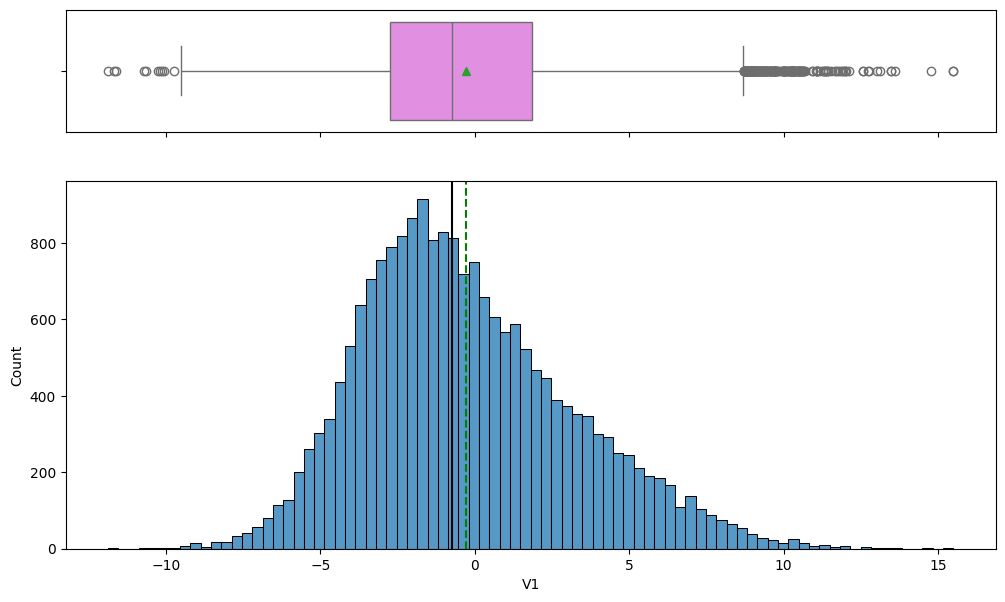

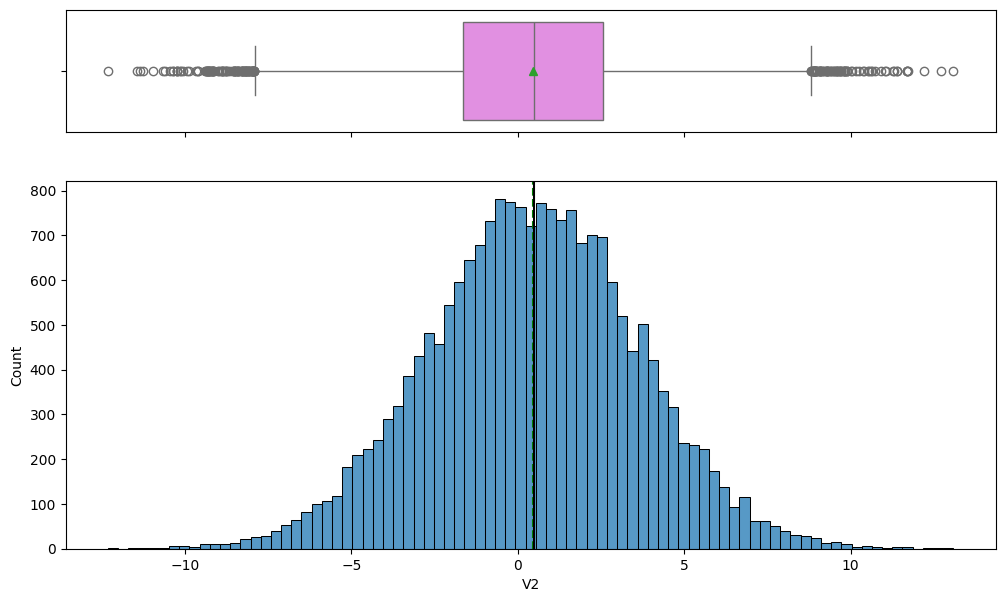

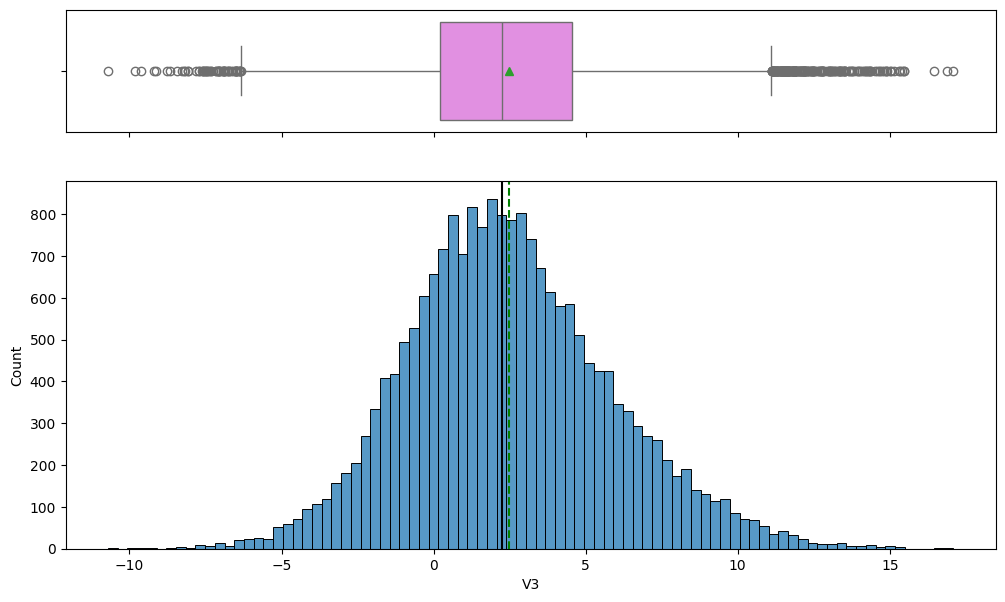

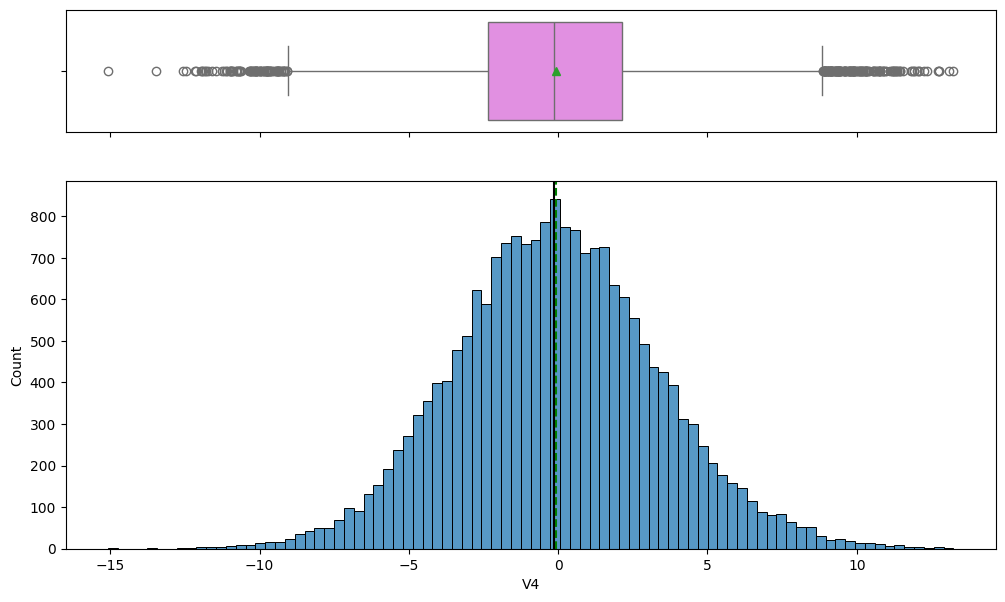

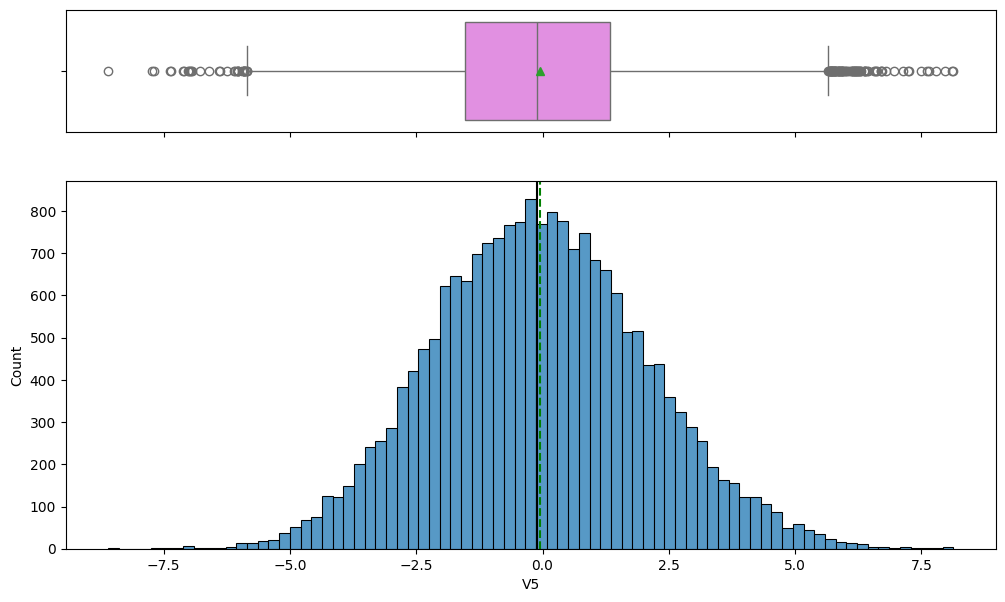

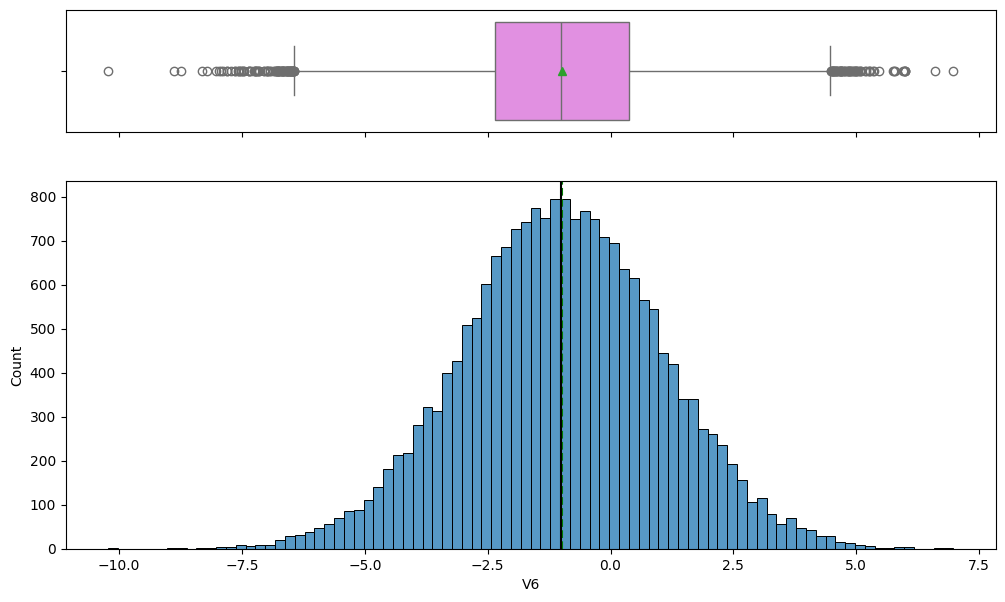

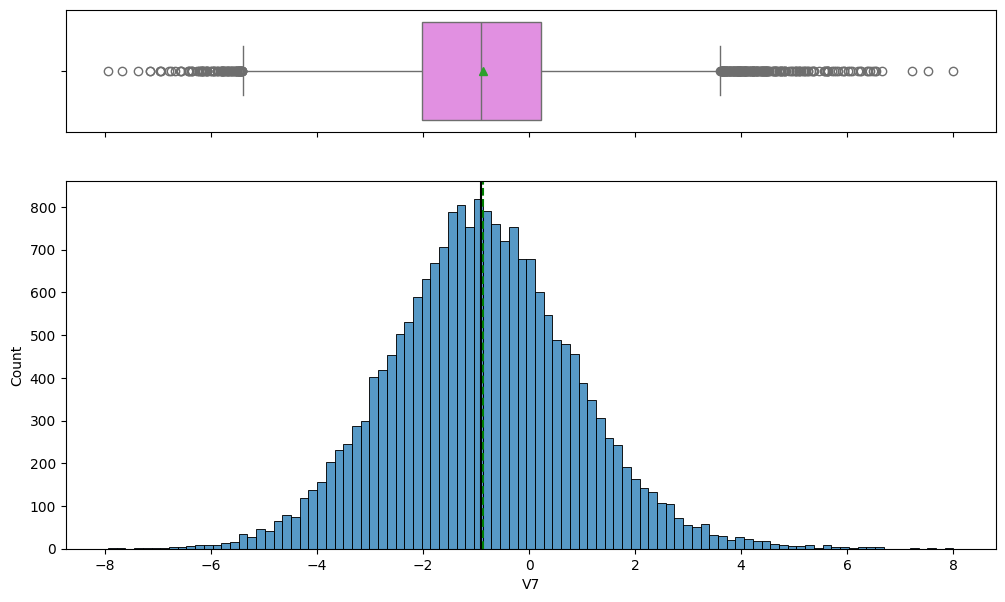

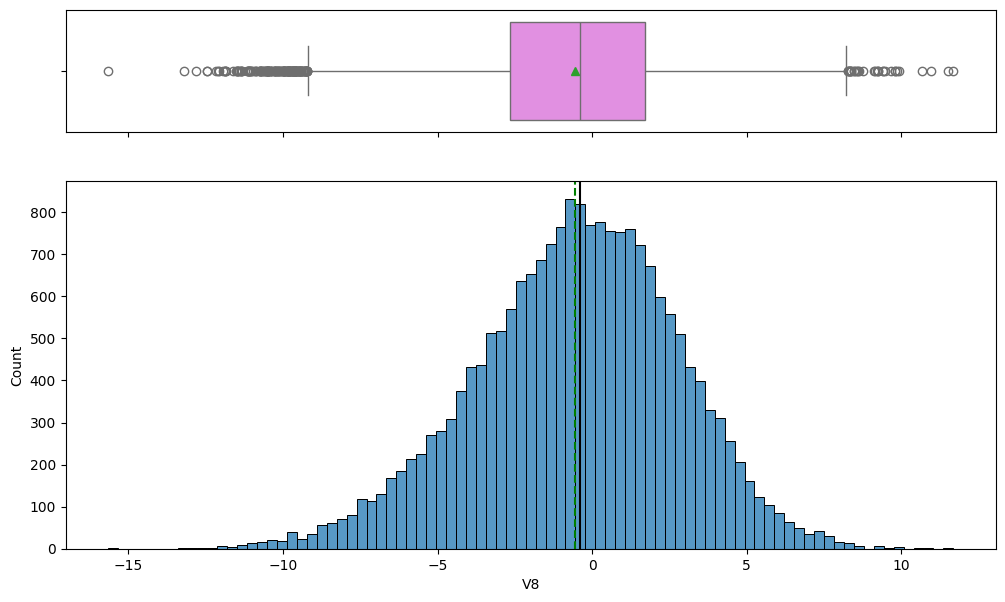

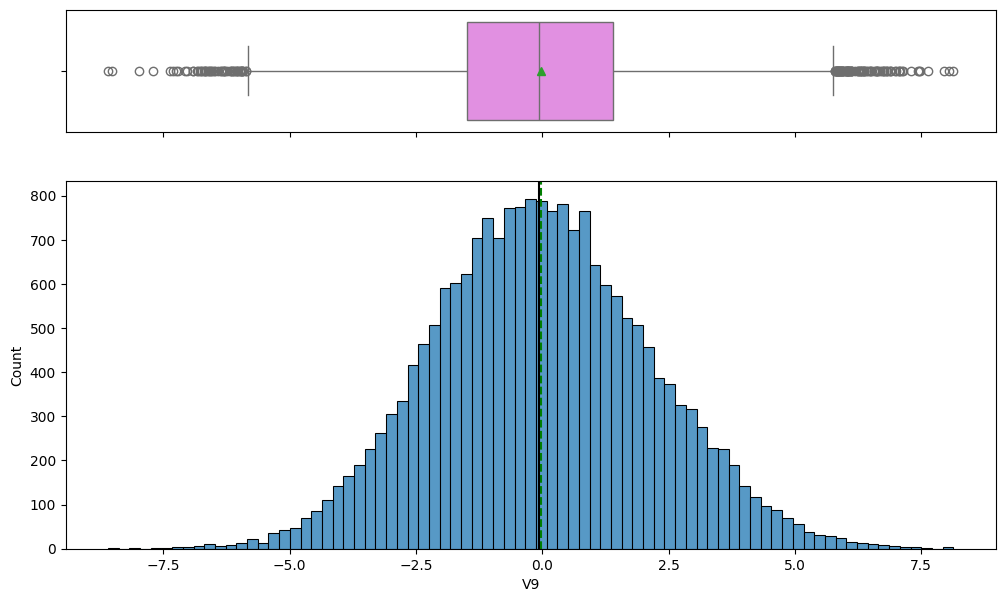

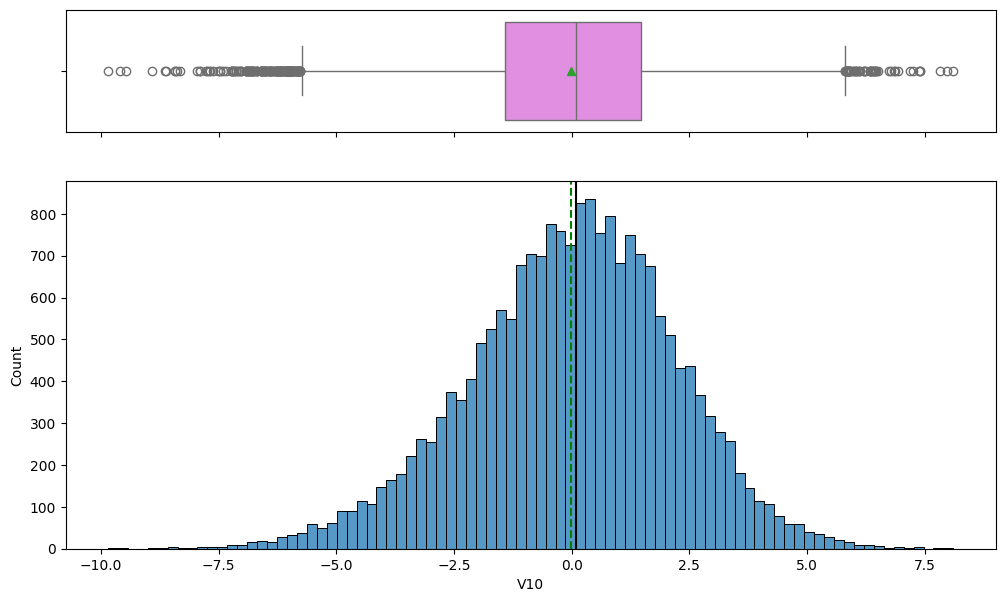

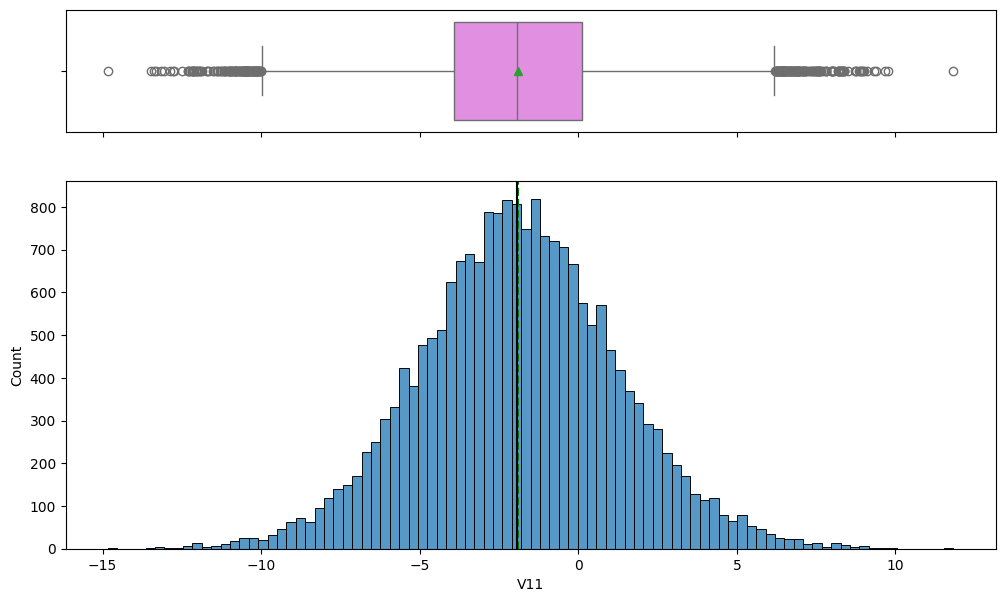

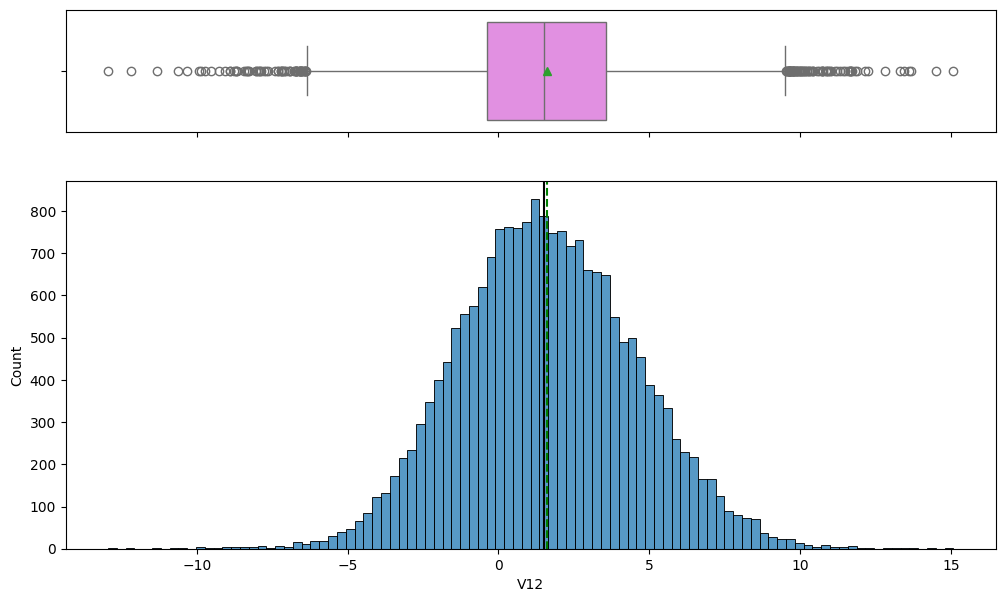

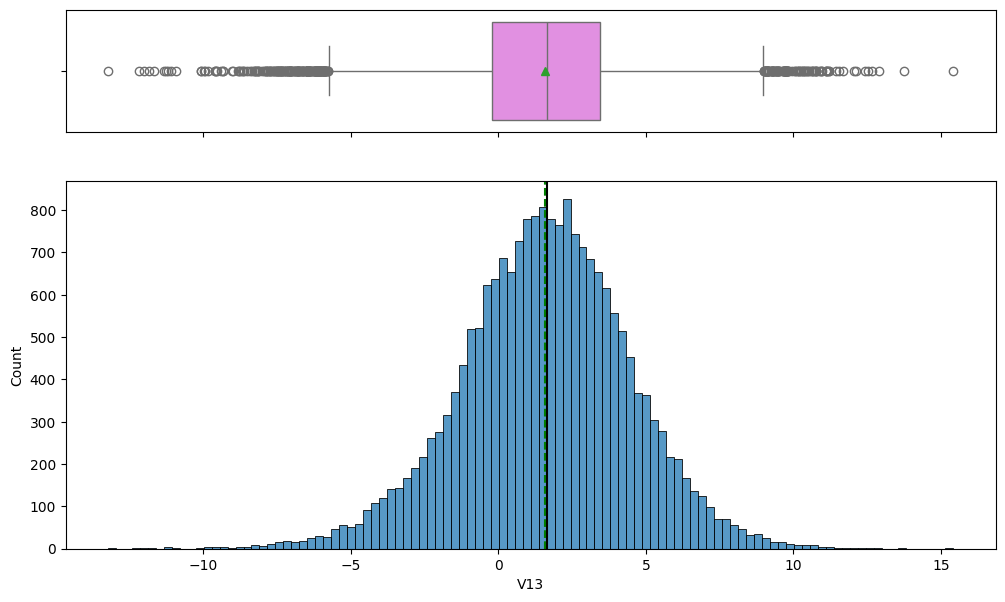

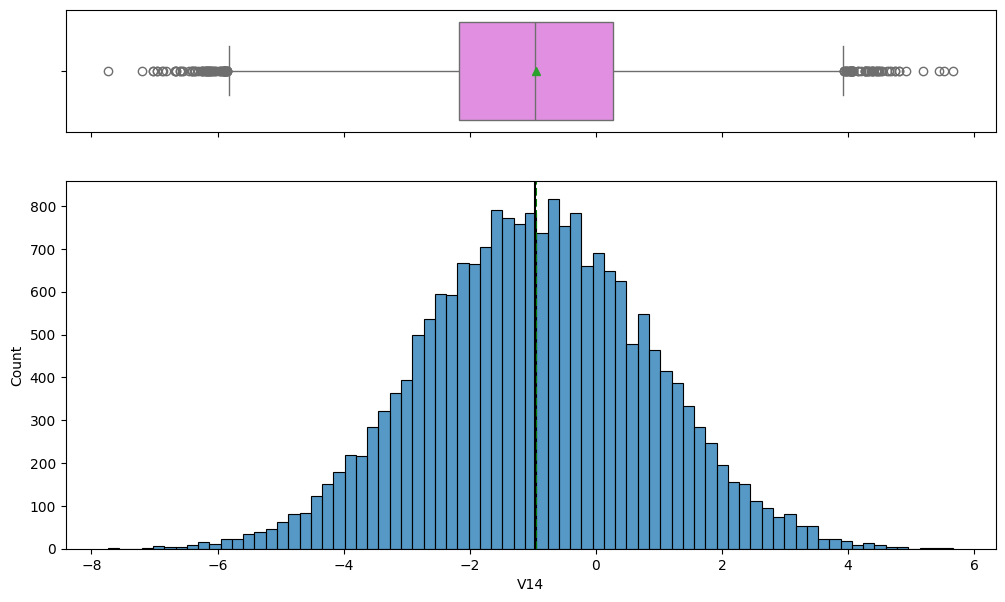

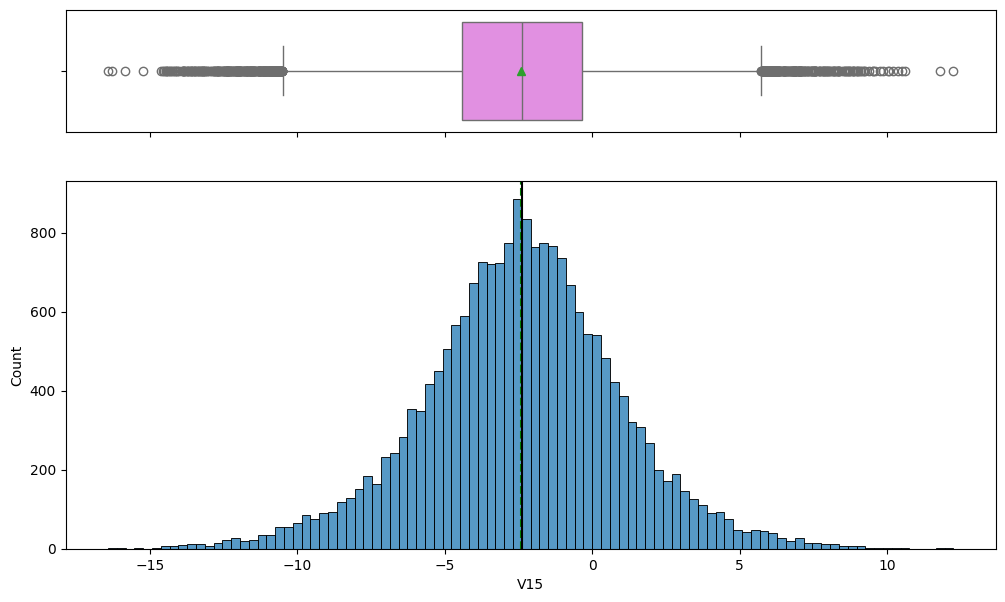

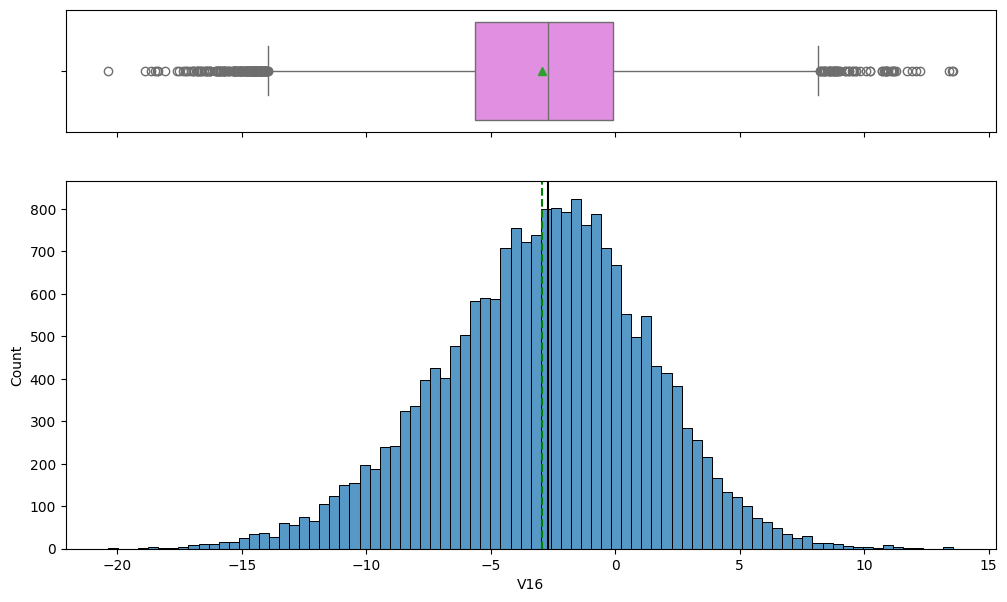

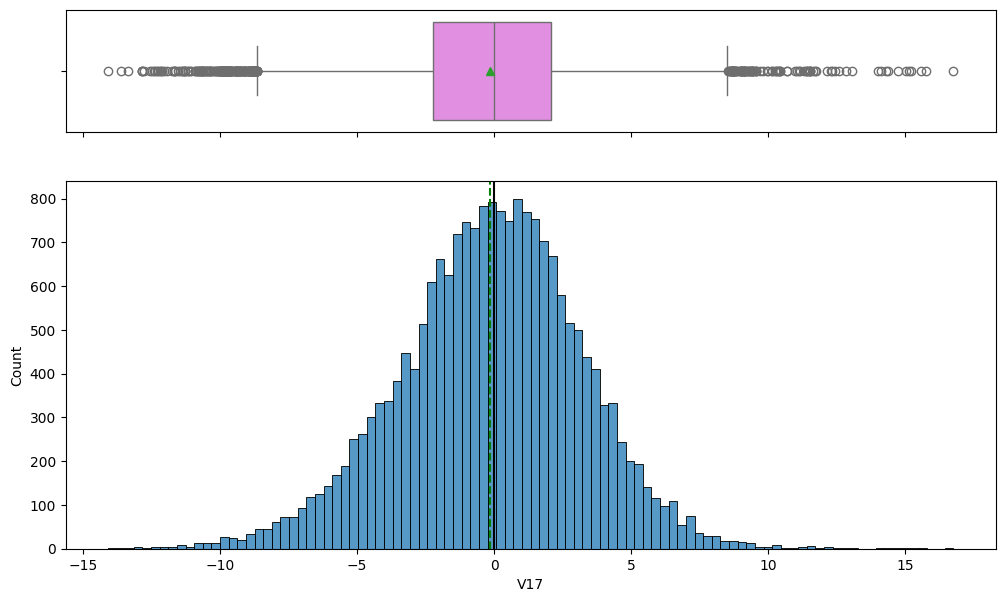

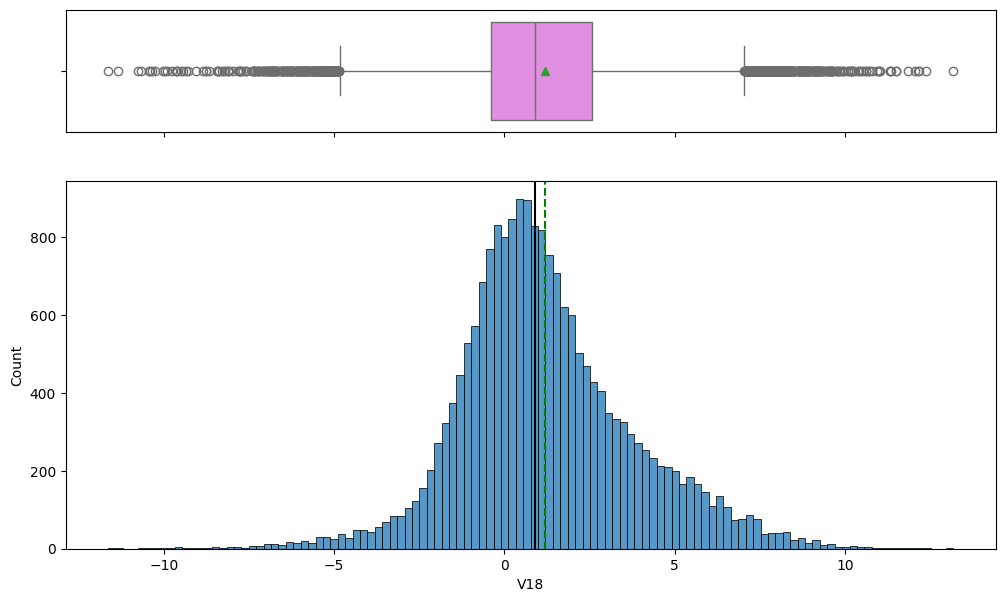

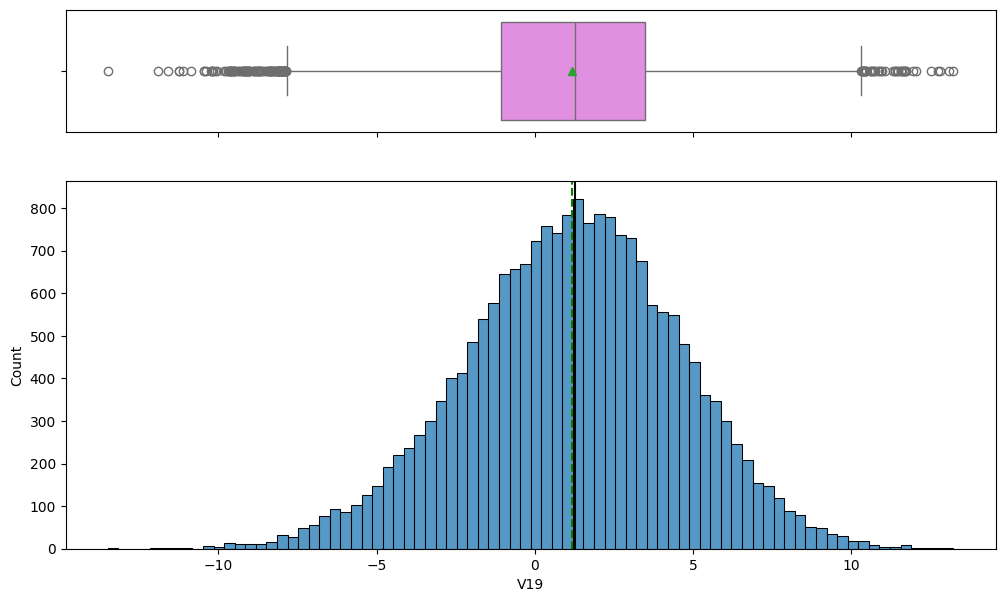

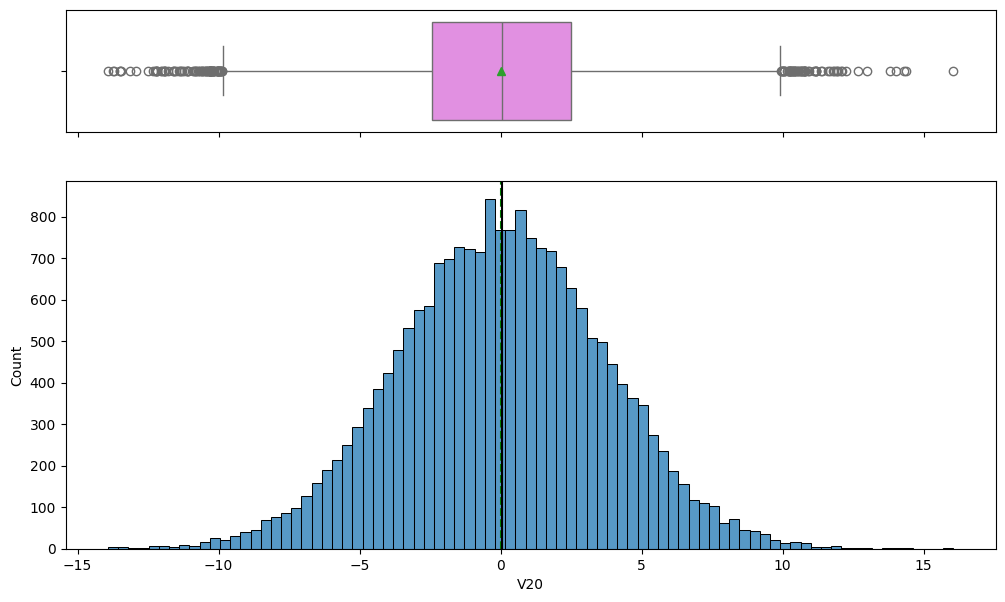

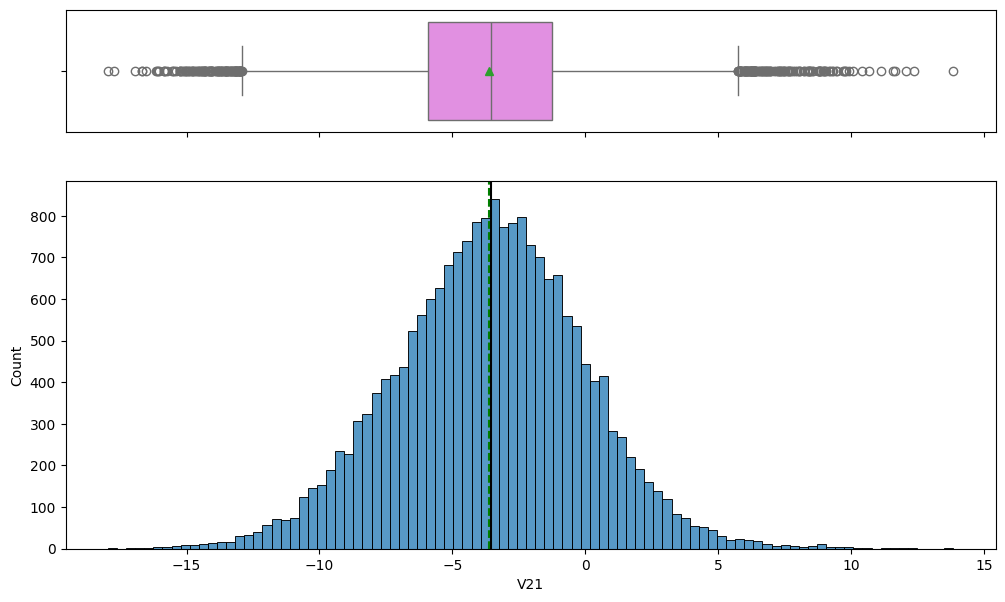

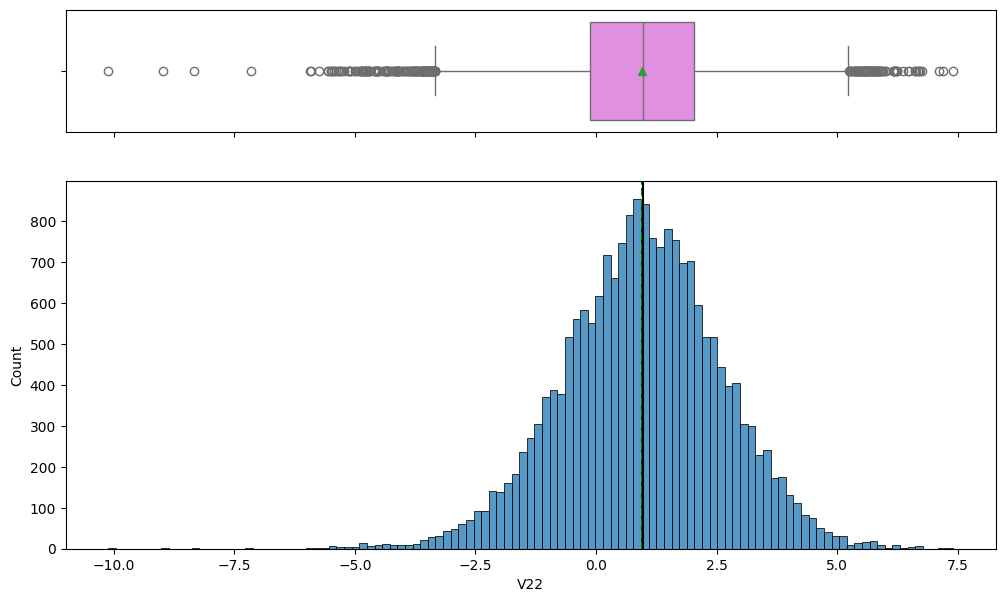

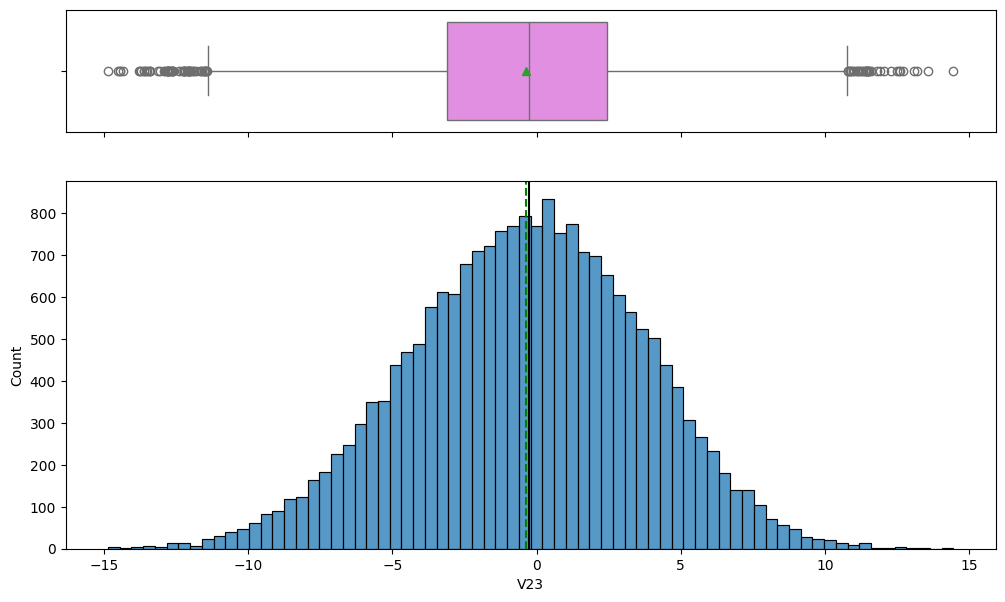

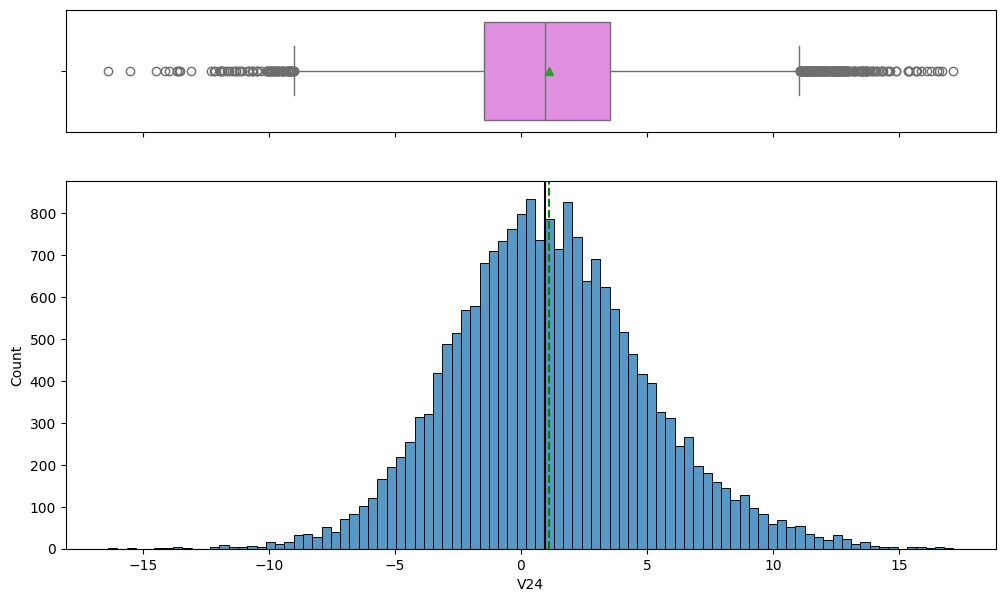

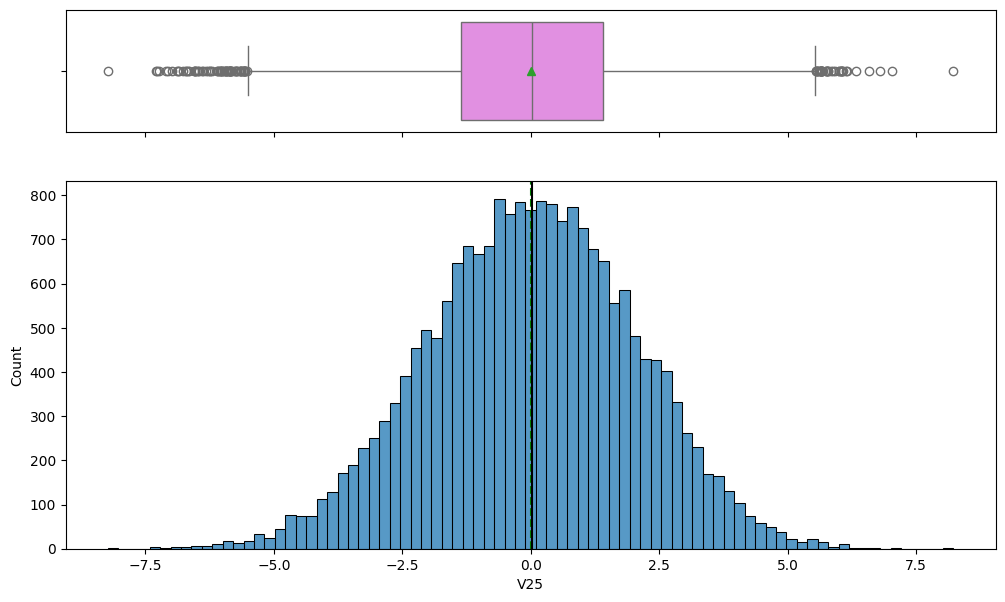

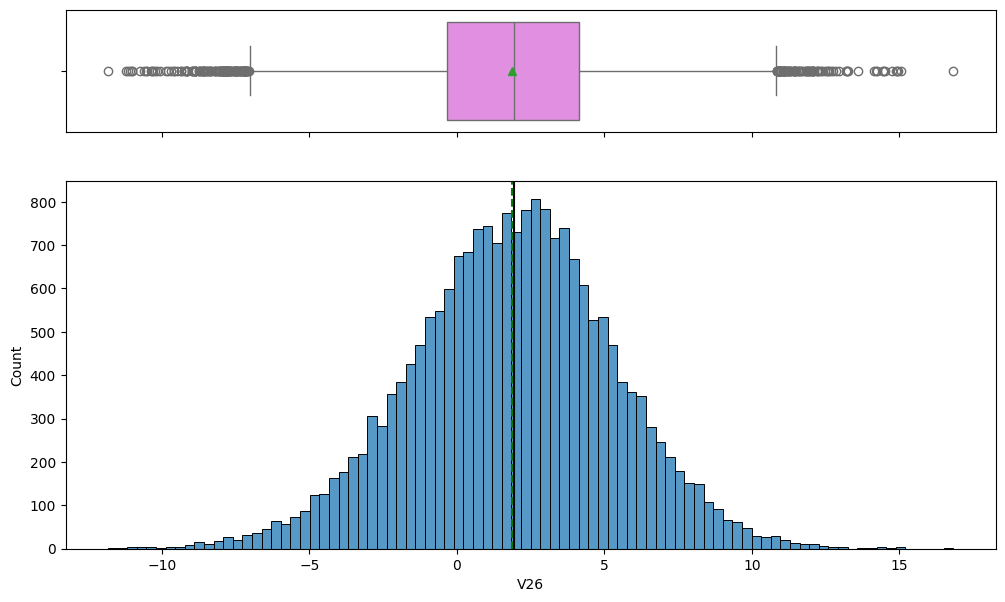

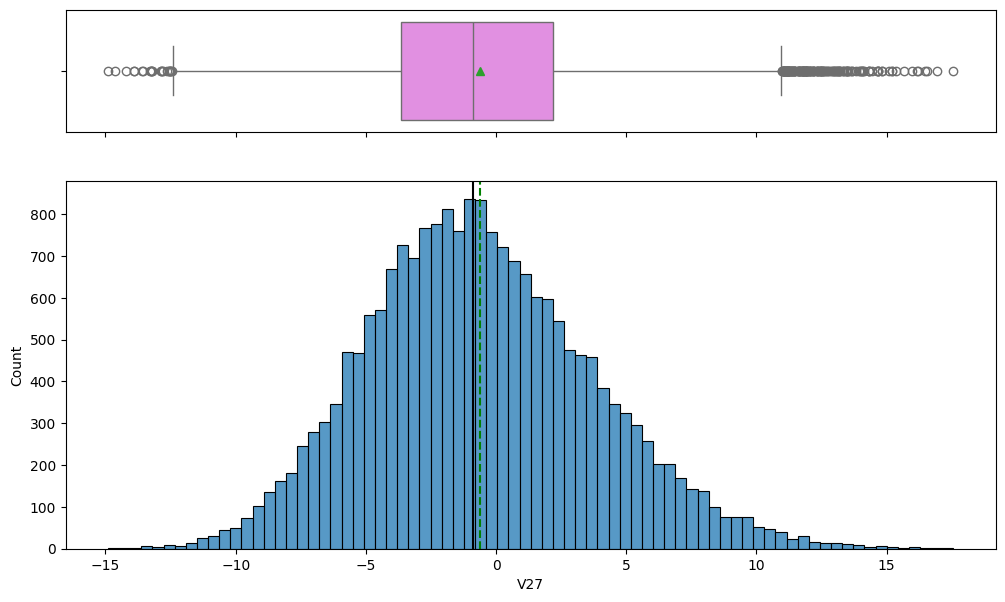

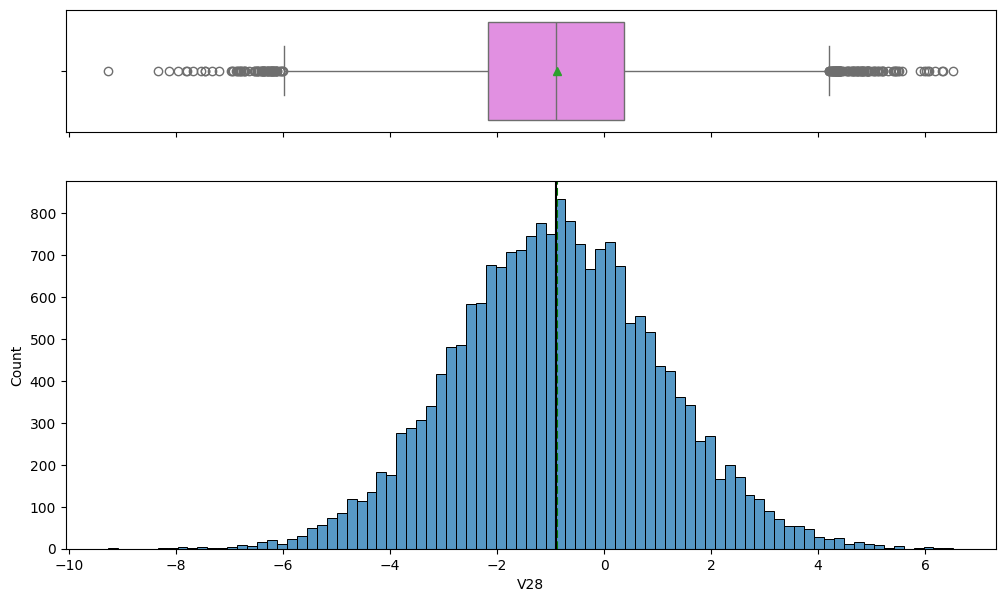

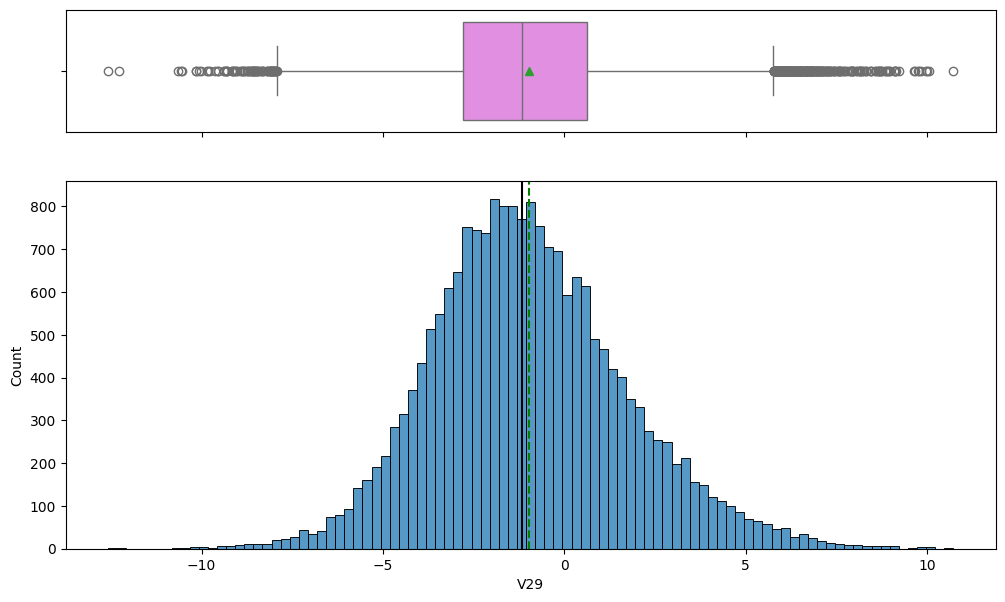

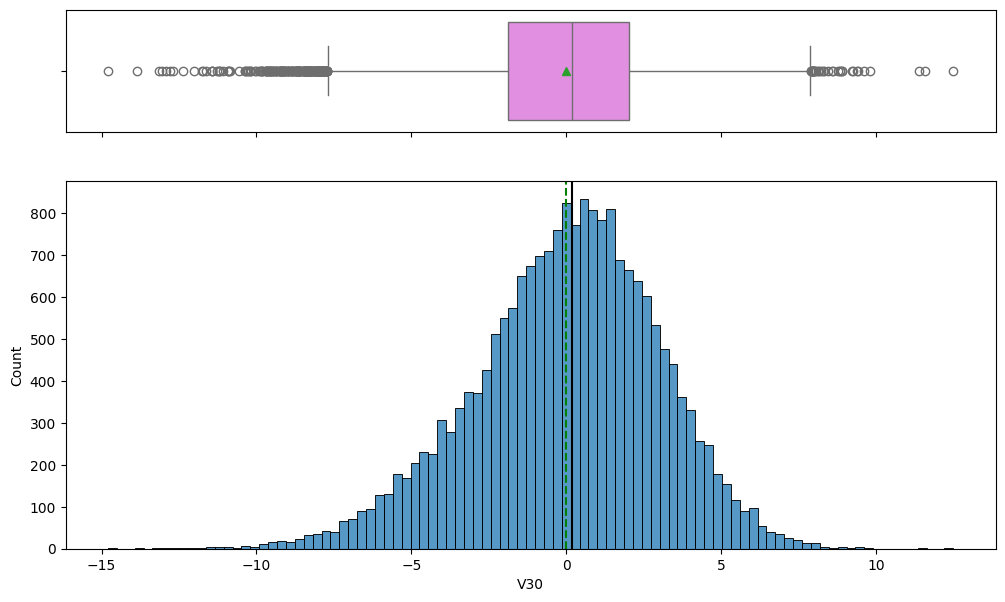

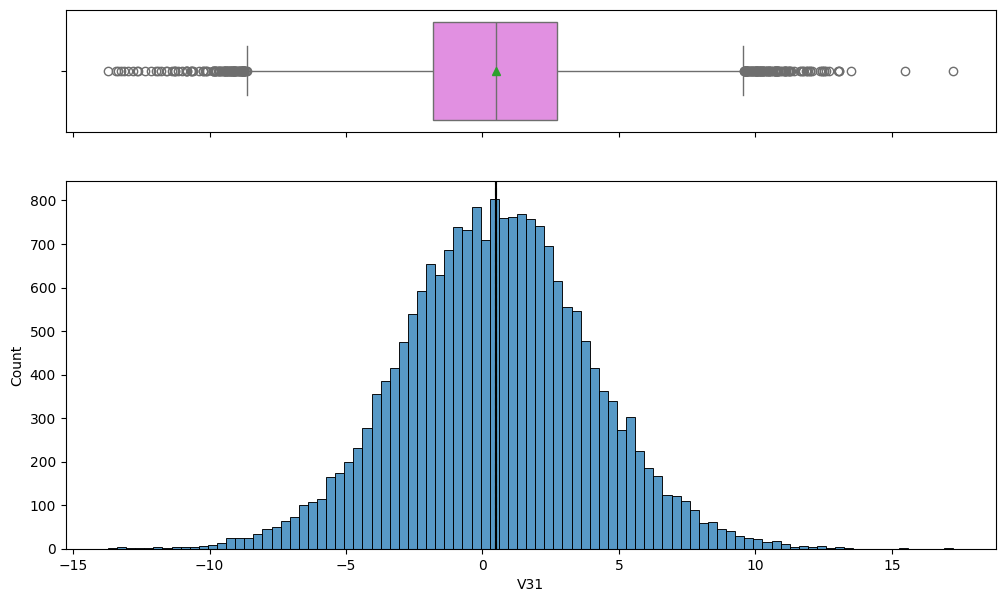

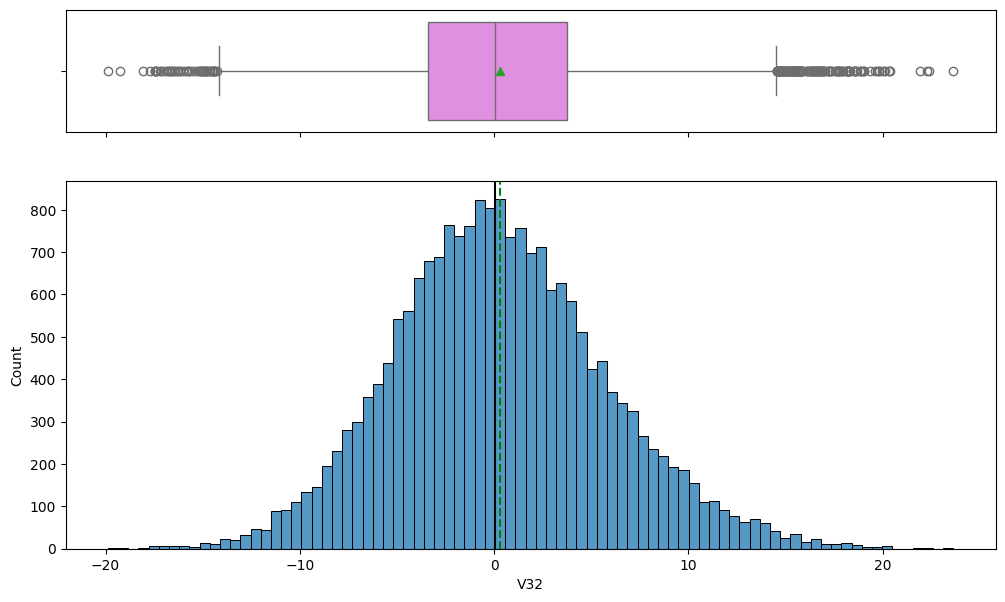

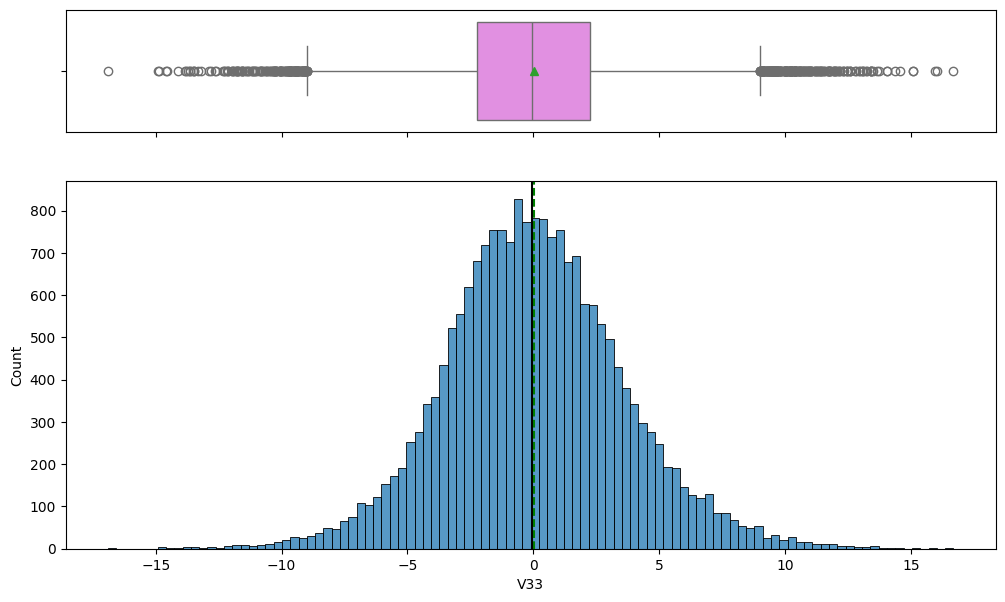

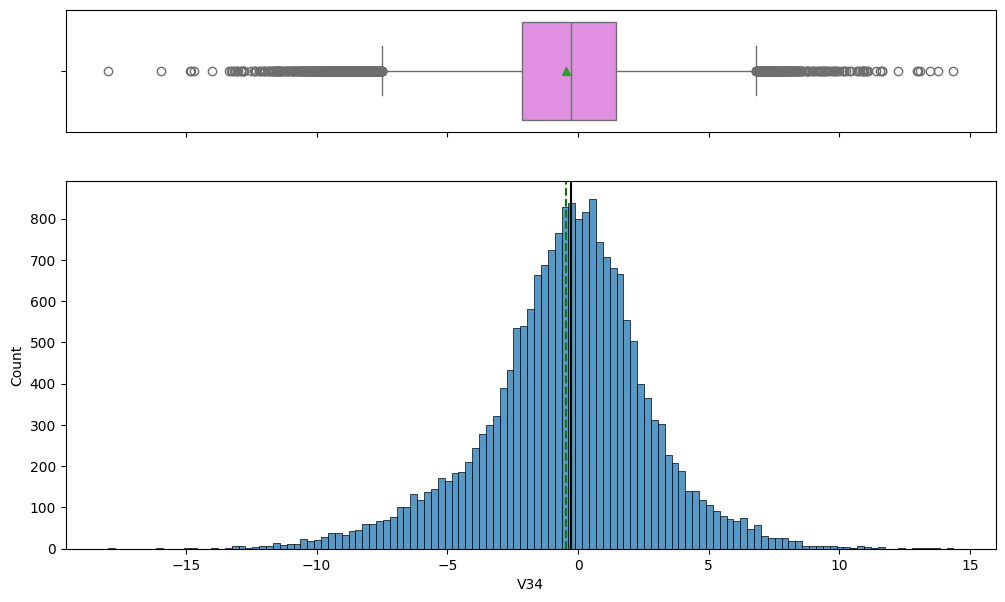

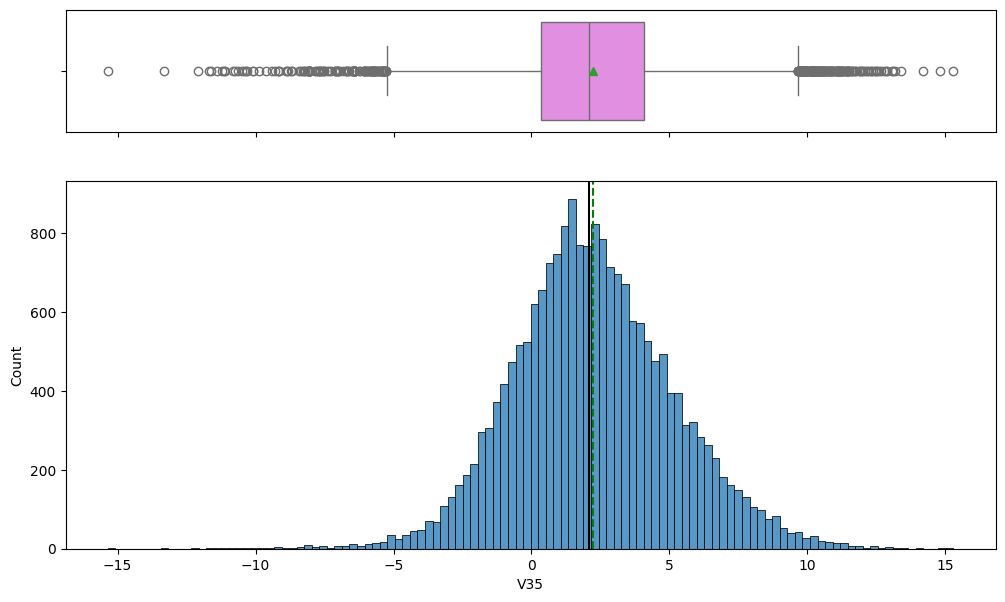

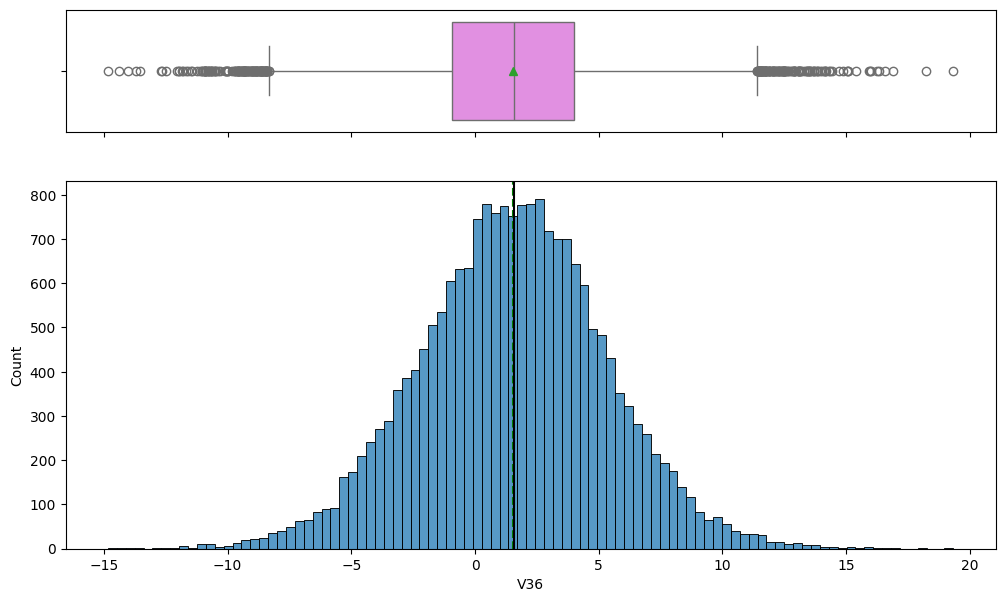

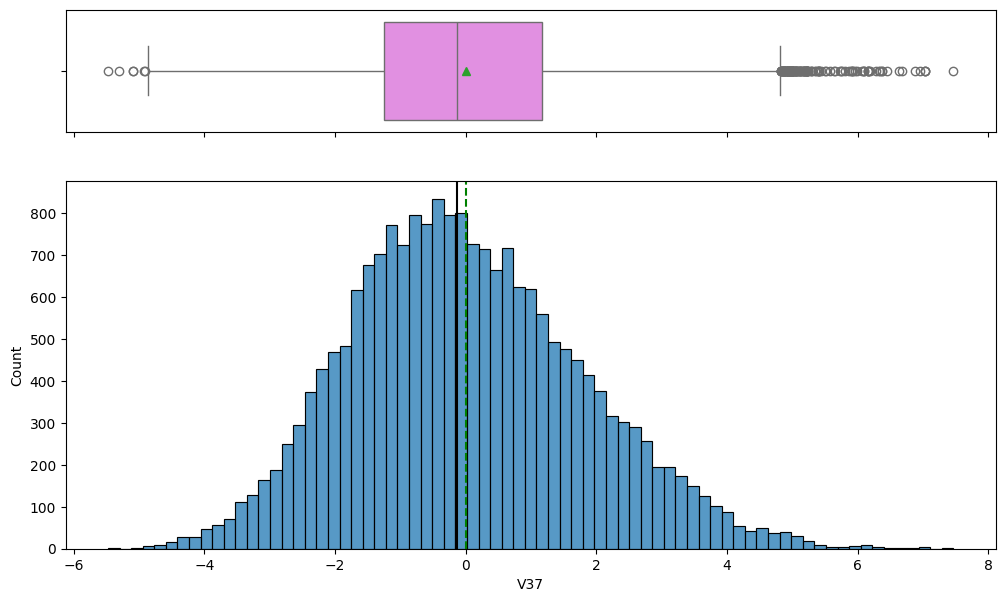

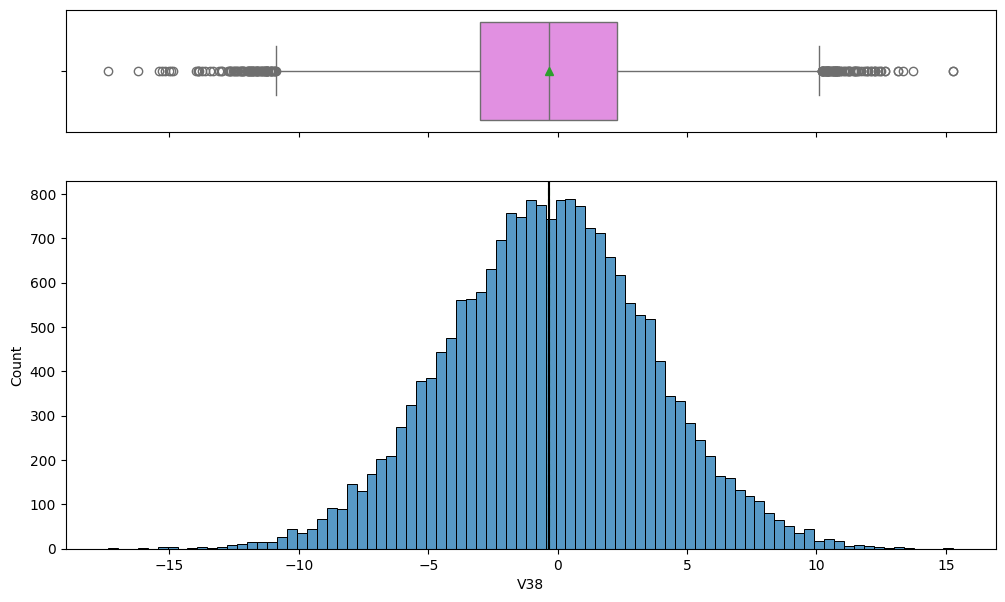

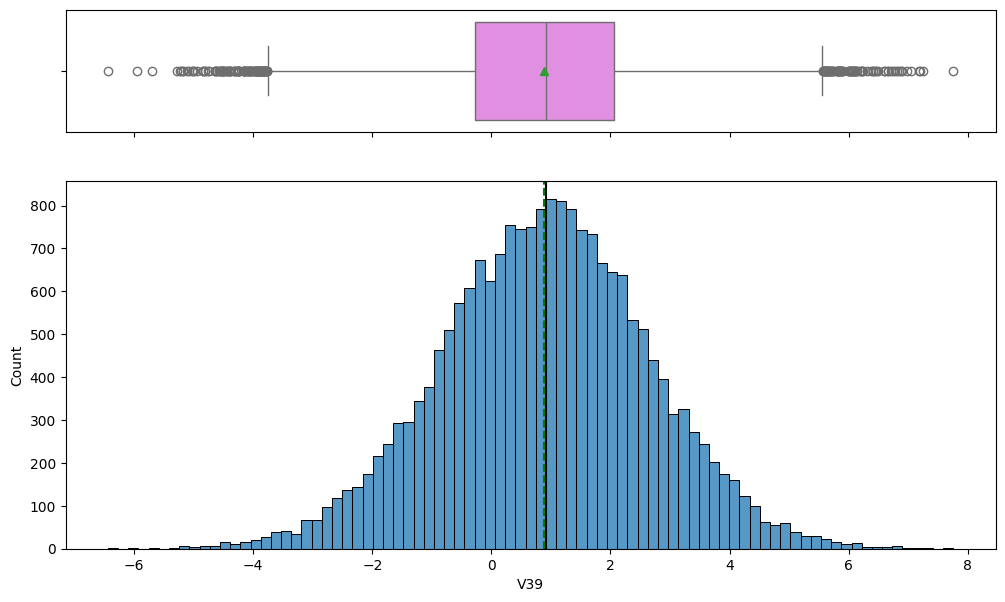

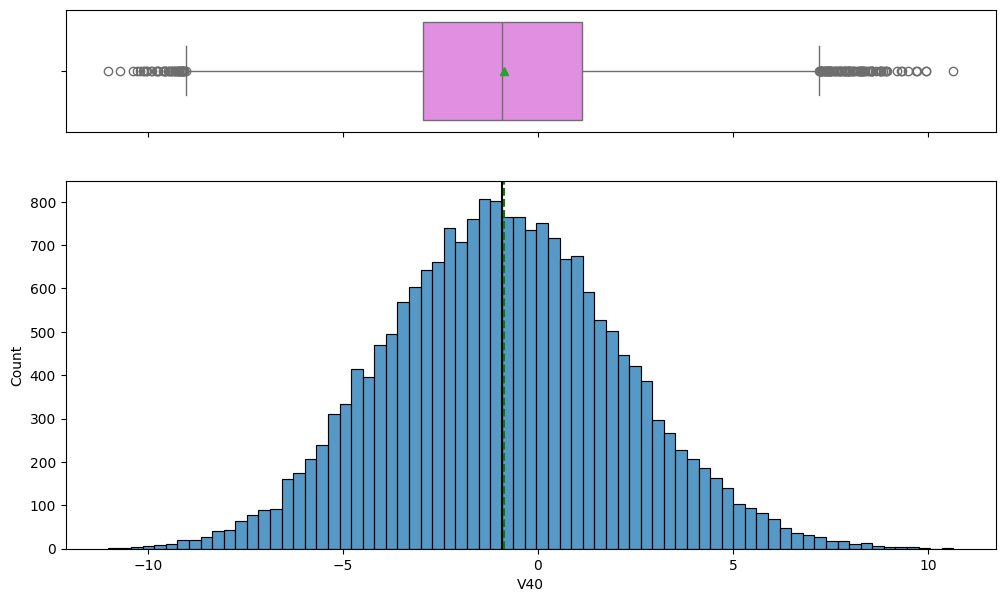

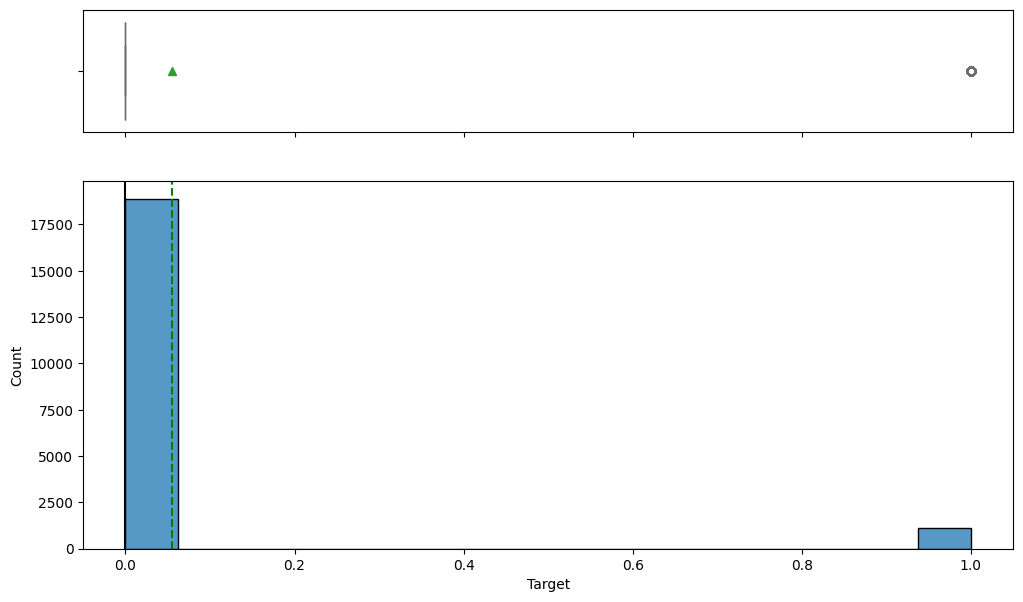

In [16]:
for feature in train.columns:
    histogram_boxplot(train, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data

## Data Pre-processing

In [17]:
from scipy.stats import zscore

# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_dict[col] = len(outliers)
    return outlier_dict

# Function to detect outliers using Z-score
def detect_outliers_zscore(df, columns, threshold=3):
    outlier_dict = {}
    for col in columns:
        z_scores = np.abs(zscore(df[col]))
        outliers = df[z_scores > threshold]
        outlier_dict[col] = len(outliers)
    return outlier_dict

# Select numerical columns (excluding target)
num_cols = [col for col in train.columns if col != "Target"]

# Detect outliers
iqr_outliers = detect_outliers_iqr(train, num_cols)
zscore_outliers = detect_outliers_zscore(train, num_cols)

# Display the top features with the most outliers
iqr_sorted = sorted(iqr_outliers.items(), key=lambda x: x[1], reverse=True)
zscore_sorted = sorted(zscore_outliers.items(), key=lambda x: x[1], reverse=True)

print("Top Features with Outliers (IQR Method):", iqr_sorted[:10])
print("Top Features with Outliers (Z-score Method):", zscore_sorted[:10])

Top Features with Outliers (IQR Method): [('V34', 803), ('V18', 731), ('V15', 513), ('V33', 383), ('V29', 336), ('V35', 315), ('V24', 307), ('V13', 303), ('V17', 296), ('V7', 291)]
Top Features with Outliers (Z-score Method): [('V34', 183), ('V18', 172), ('V15', 145), ('V33', 141), ('V35', 133), ('V13', 127), ('V7', 116), ('V21', 114), ('V17', 112), ('V29', 111)]


##### Failures Relationship to outliers

- Feature with most outliers

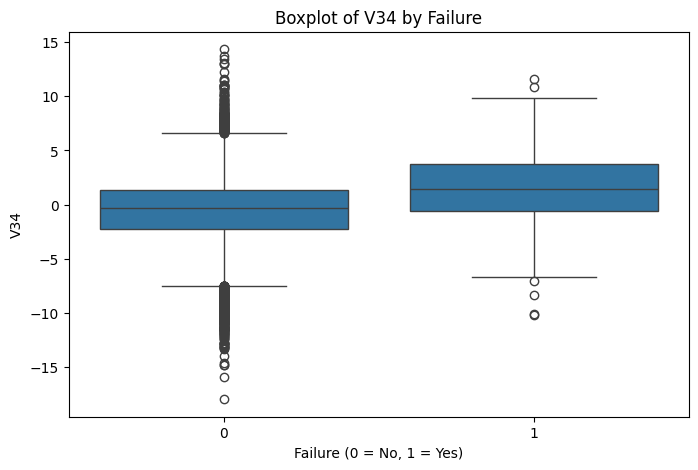

In [18]:
# Select top feature with most outliers
top_feature = iqr_sorted[0][0]

plt.figure(figsize=(8, 5))
sns.boxplot(x=train["Target"], y=train[top_feature])
plt.title(f"Boxplot of {top_feature} by Failure")
plt.xlabel("Failure (0 = No, 1 = Yes)")
plt.ylabel(top_feature)
plt.show()

- Feature with second most outliers

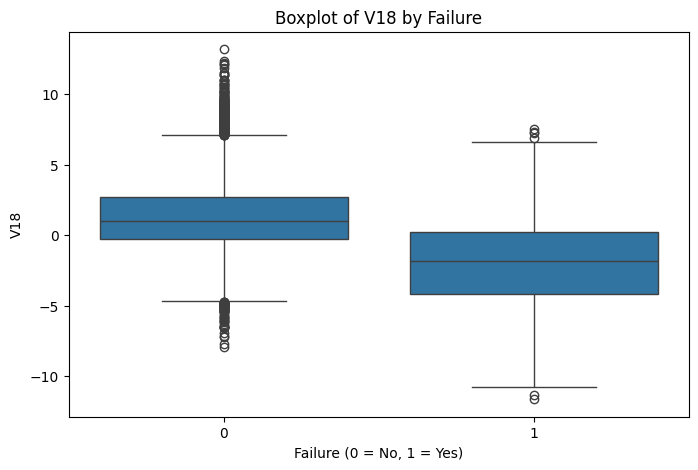

In [19]:
top_feature = iqr_sorted[1][0]

plt.figure(figsize=(8, 5))
sns.boxplot(x=train["Target"], y=train[top_feature])
plt.title(f"Boxplot of {top_feature} by Failure")
plt.xlabel("Failure (0 = No, 1 = Yes)")
plt.ylabel(top_feature)
plt.show()

- Feature with third most outliers

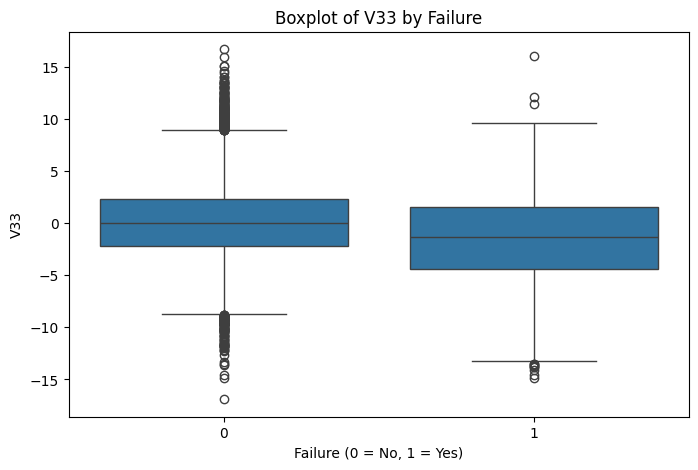

In [20]:
top_feature = iqr_sorted[3][0]

plt.figure(figsize=(8, 5))
sns.boxplot(x=train["Target"], y=train[top_feature])
plt.title(f"Boxplot of {top_feature} by Failure")
plt.xlabel("Failure (0 = No, 1 = Yes)")
plt.ylabel(top_feature)
plt.show()

- It appears that failures do not have a relationship with outliers

In [21]:
scaler = RobustScaler()
train_scaled = train.copy()
train_scaled[num_cols] = scaler.fit_transform(train[num_cols])

Since the outliers are not strongly correlated with failures, removing them is unnecessary. Instead, they should be normalized to prevent them from negatively impacting the model.

Why RobustScaler

- Preserves all data (no removals, no loss of useful information).
- Reduces outlier influence (scales using median & IQR instead of mean & standard deviation).
- Better for models like Logistic Regression, Decision Trees, and Gradient Boosting, which are sensitive to feature scale.

#### Test Dataset

- Apply the same RobustScaler transformation to the test dataset, but do not fit it again. Instead, use the scaler already fitted on the training data to ensure consistency. 

If you apply different transformations to the test data, the model will receive differently scaled inputs, leading to incorrect predictions.

- Since the test dataset follows a similar distribution to the training set, repeating the analysis is unnecessary. The same preprocessing steps must be applied to avoid data leakage.

In [22]:
# Apply the same scaler (DO NOT FIT AGAIN)
test[num_cols] = scaler.transform(test[num_cols])

### Missing value imputation

In [23]:
# show only missing values
test.isnull().sum()[test.isnull().sum() > 0]

V1    5
V2    6
dtype: int64

In [24]:
# show only missing values
train.isnull().sum()[train.isnull().sum() > 0]

V1    18
V2    18
dtype: int64

In [29]:
train.fillna(train.median(), inplace=True)
test.fillna(train.median(), inplace=True)  # Use training set median to avoid data leakage

### Dealing With class imbalance

In [ ]:
# Recommended for boosting and tree-based models
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train["Target"]), y=train["Target"])
weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
print("Class Weights:", weights_dict) 

Class Weights: {0: np.float64(0.5293806246691372), 1: np.float64(9.00900900900901)}


- Use class weight to give failures more importance in the model training.

### Feature Selection

In [ ]:
# Identify numerical columns (excluding Target) Re define the num_cols (not necessary)
num_cols = [col for col in train.columns if col != "Target"]

In [ ]:
# Compute Correlation Matrix
correlation_matrix = train[num_cols].corr()

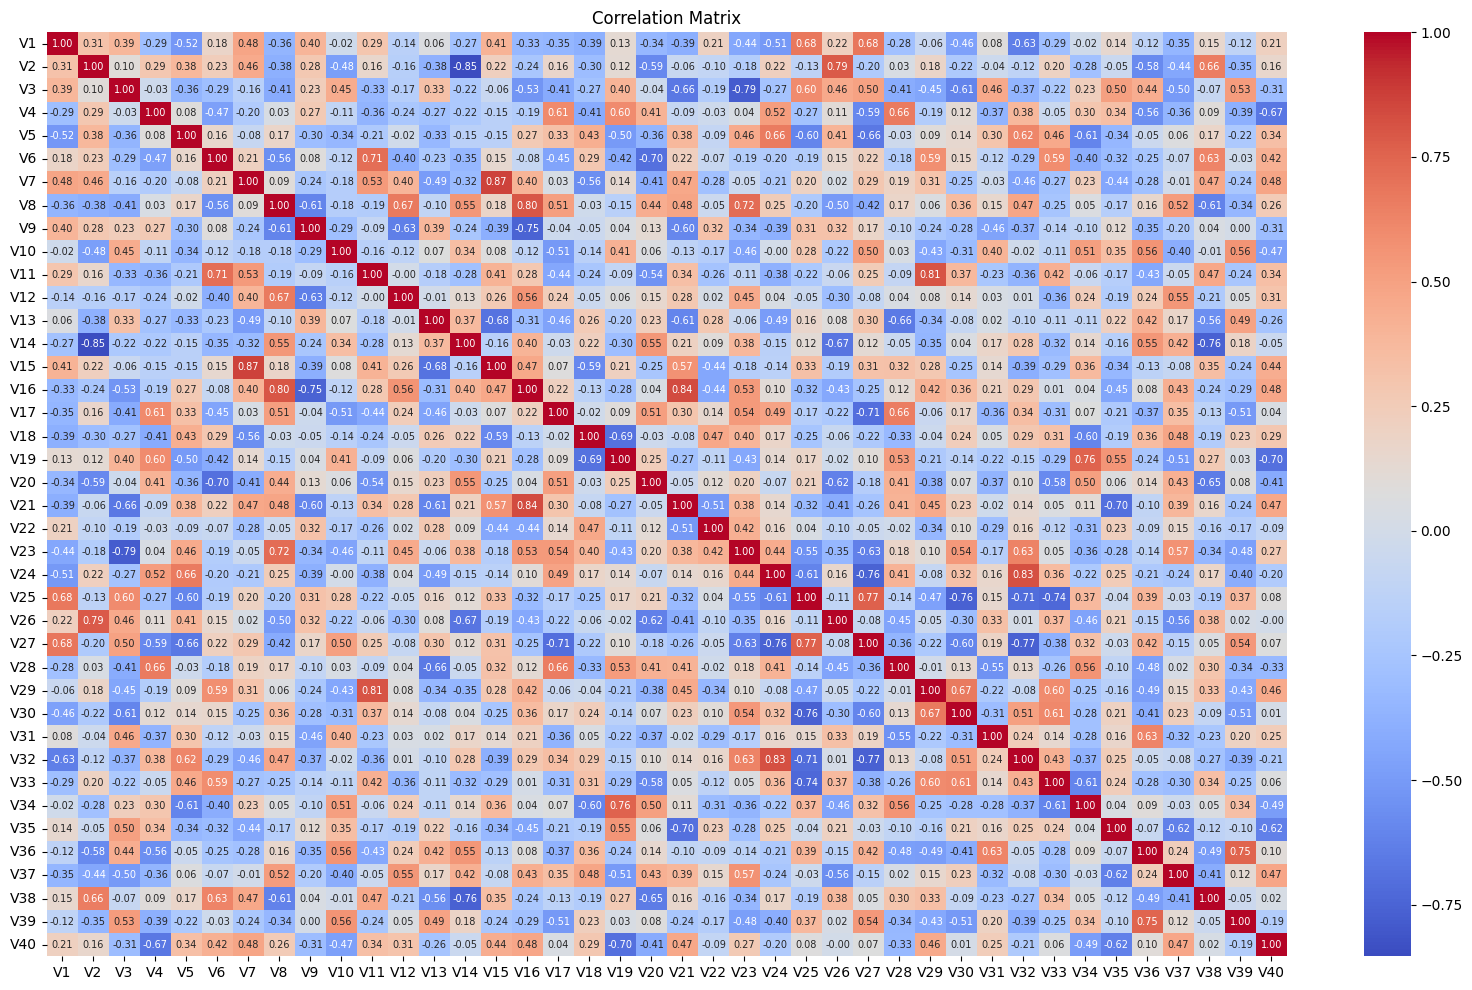

In [36]:
# plot the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 7})
plt.title("Correlation Matrix")

plt.show()

In [37]:
# Identify Highly Correlated Features (Threshold: 0.85)
correlation_threshold = 0.85
highly_correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

# Print Highly Correlated Features
print("Highly Correlated Features to Drop:", highly_correlated_features)

Highly Correlated Features to Drop: {'V15', 'V14'}


In [43]:
# Get feature importance using Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train[num_cols], train["Target"])

RandomForestClassifier(random_state=42)

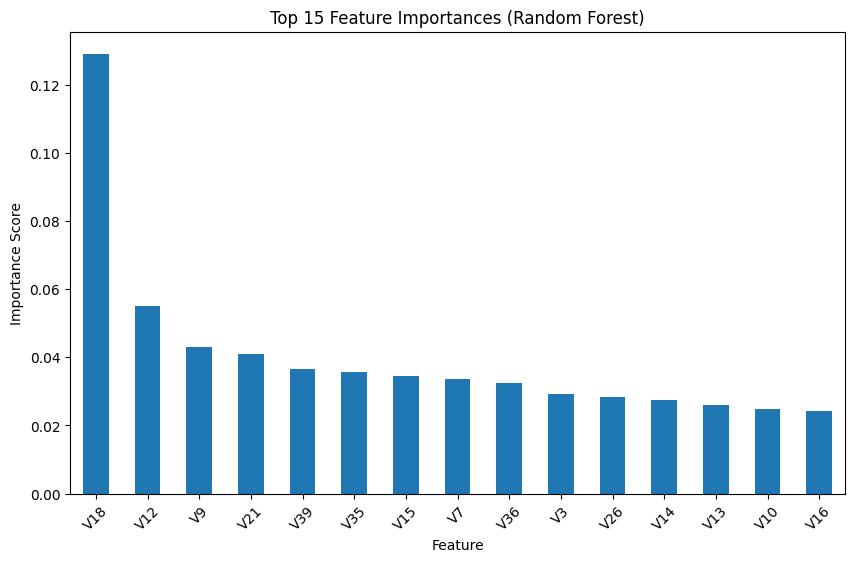

V18   0.129
V12   0.055
V9    0.043
V21   0.041
V39   0.036
V35   0.036
V15   0.035
V7    0.034
V36   0.033
V3    0.029
V26   0.028
V14   0.028
V13   0.026
V10   0.025
V16   0.024
dtype: float64

In [44]:
# Get feature importance scores
importances = pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=False)

# Display feature importance as a bar plot
plt.figure(figsize=(10, 6))
importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.show()

# Return top 15 most important features
importances.head(15)

- Since `V15` and `V14` are highly correlated with other features, they are dropped to prevent redundancy

In [45]:
# Drop highly correlated features from train & test datasets
train.drop(columns=['V15', 'V14'], inplace=True)
test.drop(columns=['V15', 'V14'], inplace=True) 

### Prepare Data for Model Training

In [46]:
# Separate features and target
X_train = train.drop(columns=["Target"])
y_train = train["Target"]

X_test = test.drop(columns=["Target"])
y_test = test["Target"]

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

Sample Decision Tree model building with original data

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))

### Model Building with Oversampled data


In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

### Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

## HyperparameterTuning

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Sample tuning method for Decision tree with original data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

### Sample tuning method for Decision tree with oversampled data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

### Sample tuning method for Decision tree with undersampled data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

## Model performance comparison and choosing the final model

### Test set final performance

## Pipelines to build the final model


# Business Insights and Conclusions

***